Ноутбук для генерации подписей к изображению с помощью Socratic Models

## Установим зависимости

In [ ]:
openai_api_key = "" # insert yours

In [ ]:
!pip install ftfy regex tqdm fvcore imageio imageio-ffmpeg openai pattern
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
!pip install profanity-filter
!python -m spacy download en

In [ ]:
import datetime
import json
import os
import re
import time

import requests
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openai
from PIL import Image
from profanity_filter import ProfanityFilter
import torch

openai.api_key = openai_api_key

## Выберем, какие версии моделей будем использовать и загрузим их веса

In [ ]:
clip_version = "ViT-L/14"
gpt_version = "text-davinci-002" 
clip_feat_dim = 768

In [ ]:
model, preprocess = clip.load(clip_version)  # clip.available_models()
model.cuda().eval()
img_size = model.visual.input_resolution

## Опишем вспомогательные фун

get_text_feats - получить представления текста из CLIP \\
get_img_feats - получить представления картинок из CLIP \\
get_nn_text - получить скор согласованности представления текстов и представления картинки


In [ ]:
def get_text_feats(in_text, batch_size=64):
  text_tokens = clip.tokenize(in_text).cuda()
  text_id = 0
  text_feats = np.zeros((len(in_text), clip_feat_dim), dtype=np.float32)
  while text_id < len(text_tokens):
    batch_size = min(len(in_text) - text_id, batch_size)
    text_batch = text_tokens[text_id:text_id+batch_size]
    with torch.no_grad():
      batch_feats = model.encode_text(text_batch).float()
    batch_feats /= batch_feats.norm(dim=-1, keepdim=True)
    batch_feats = np.float32(batch_feats.cpu())
    text_feats[text_id:text_id+batch_size, :] = batch_feats
    text_id += batch_size
  return text_feats

def get_img_feats(img):
  img_pil = Image.fromarray(np.uint8(img))
  img_in = preprocess(img_pil)[None, ...]
  with torch.no_grad():
    img_feats = model.encode_image(img_in.cuda()).float()
  img_feats /= img_feats.norm(dim=-1, keepdim=True)
  img_feats = np.float32(img_feats.cpu())
  return img_feats

def get_nn_text(raw_texts, text_feats, img_feats):
  scores = text_feats @ img_feats.T
  scores = scores.squeeze()
  high_to_low_ids = np.argsort(scores).squeeze()[::-1]
  high_to_low_texts = [raw_texts[i] for i in high_to_low_ids]
  high_to_low_scores = np.sort(scores).squeeze()[::-1]
  return high_to_low_texts, high_to_low_scores

prompt_llm -  спросить промпт у LLM

In [ ]:
def prompt_llm(prompt, max_tokens=64, temperature=0, stop=None):
  response = openai.Completion.create(engine=gpt_version, prompt=prompt, max_tokens=max_tokens, temperature=temperature, stop=stop)
  return response["choices"][0]["text"].strip()

Cкачаем текстовые категории мест, изображенных на картинках, например \\
airfield \\
airplane_cabin \\
airport_terminal \\
и посчитаем представления текста "Изображение {категория картинки}" для всех категорий

In [ ]:
# Load scene categories from Places365.
if not os.path.exists('categories_places365.txt'):
  ! wget https://raw.githubusercontent.com/zhoubolei/places_devkit/master/categories_places365.txt
place_categories = np.loadtxt('categories_places365.txt', dtype=str)
place_texts = []
for place in place_categories[:, 0]:
  place = place.split('/')[2:]
  if len(place) > 1:
    place = place[1] + ' ' + place[0]
  else:
    place = place[0]
  place = place.replace('_', ' ')
  place_texts.append(place)
place_feats = get_text_feats([f'Image of a {p}.' for p in place_texts])

Cкачаем текстовые категории объектов, изображенных на картинках, например \\
mozzarella \\
sky \\
hair \\
и посчитаем представления текста "Изображение {категория картинки}" для всех категорий

In [ ]:
# Load object categories from Tencent ML Images.
if not os.path.exists('dictionary_and_semantic_hierarchy.txt'):
  ! wget https://raw.githubusercontent.com/Tencent/tencent-ml-images/master/data/dictionary_and_semantic_hierarchy.txt
with open('dictionary_and_semantic_hierarchy.txt') as fid:
    object_categories = fid.readlines()
object_texts = []
for object_text in object_categories[1:]:
  object_text = object_text.strip()
  object_text = object_text.split('\t')[3]
  safe_list = ''
  for variant in object_text.split(','):
    text = variant.strip()
    safe_list += f'{text}, '
  safe_list = safe_list[:-2]
  if len(safe_list) > 0:
    object_texts.append(safe_list)
object_texts = [o for o in list(set(object_texts)) if o not in place_texts]  # Remove redundant categories.
object_feats = get_text_feats([f'Image of a {o}.' for o in object_texts])

## Опишем генерацию подписей

In [ ]:
def get_pic_caption(img_url, verbose=True):
  fname = 'demo_img.png'
  with open(fname, 'wb') as f:
      f.write(requests.get(img_url).content)


  # Load image.
  img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
  # Calculte image features
  img_feats = get_img_feats(img)
  plt.imshow(img); plt.show()

  # Zero-shot VLM: classify image type.
  img_types = ['photo', 'cartoon', 'sketch', 'painting']
  img_types_feats = get_text_feats([f'This is a {t}.' for t in img_types])
  sorted_img_types, img_type_scores = get_nn_text(img_types, img_types_feats, img_feats)
  img_type = sorted_img_types[0]

  # Zero-shot VLM: classify number of people.
  ppl_texts = ['no people', 'people']
  ppl_feats = get_text_feats([f'There are {p} in this photo.' for p in ppl_texts])
  sorted_ppl_texts, ppl_scores = get_nn_text(ppl_texts, ppl_feats, img_feats)
  ppl_result = sorted_ppl_texts[0]
  if ppl_result == 'people':
    ppl_texts = ['is one person', 'are two people', 'are three people', 'are several people', 'are many people']
    ppl_feats = get_text_feats([f'There {p} in this photo.' for p in ppl_texts])
    sorted_ppl_texts, ppl_scores = get_nn_text(ppl_texts, ppl_feats, img_feats)
    ppl_result = sorted_ppl_texts[0]
  else:
    ppl_result = f'are {ppl_result}'

  # Zero-shot VLM: classify places.
  place_topk = 3
  sorted_places, places_scores = get_nn_text(place_texts, place_feats, img_feats)

  # Zero-shot VLM: classify objects.
  obj_topk = 10
  sorted_obj_texts, obj_scores = get_nn_text(object_texts, object_feats, img_feats)
  object_list = ''
  for i in range(obj_topk):
    object_list += f'{sorted_obj_texts[i]}, '
  object_list = object_list[:-2]

  # Zero-shot LM: generate captions.
  num_captions = 10
  prompt = f'''I am an intelligent image captioning bot.
  This image is a {img_type}. There {ppl_result}.
  I think this photo was taken at a {sorted_places[0]}, {sorted_places[1]}, or {sorted_places[2]}.
  I think there might be a {object_list} in this {img_type}.
  A creative short caption I can generate to describe this image is:'''
  caption_texts = [prompt_llm(prompt, temperature=0.9) for _ in range(num_captions)]

  # Zero-shot VLM: rank captions.
  caption_feats = get_text_feats(caption_texts)
  sorted_captions, caption_scores = get_nn_text(caption_texts, caption_feats, img_feats)
  print(f'RESULT === {sorted_captions[0]}\n')

  if verbose:
    print(f'VLM: This image is a:')
    for img_type, score in zip(sorted_img_types, img_type_scores):
      print(f'{score:.4f} {img_type}')

    print(f'\nVLM: There:')
    for ppl_text, score in zip(sorted_ppl_texts, ppl_scores):
      print(f'{score:.4f} {ppl_text}')

    print(f'\nVLM: I think this photo was taken at a:')
    for place, score in zip(sorted_places[:place_topk], places_scores[:place_topk]):
      print(f'{score:.4f} {place}')

    print(f'\nVLM: I think there might be a:')
    for obj_text, score in zip(sorted_obj_texts[:obj_topk], obj_scores[:obj_topk]):
      print(f'{score:.4f} {obj_text}')

    print(f'\nLM generated captions ranked by VLM scores:')
    for caption, score in zip(sorted_captions, caption_scores):
      print(f'{score:.4f} {caption}')

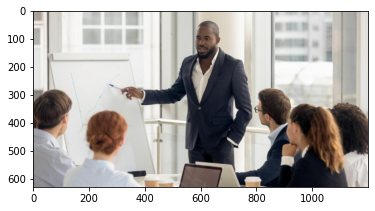

RESULT === "This is a photo of a salesperson giving a presentation to a group of people."

VLM: This image is a:
0.1126 photo
0.1055 cartoon
0.0965 sketch
0.0662 painting

VLM: There:
0.1275 no people
0.1145 people

VLM: I think this photo was taken at a:
0.1668 conference room
0.1657 office
0.1551 conference center

VLM: I think there might be a:
0.2112 chief executive officer, CEO, chief operating officer
0.2111 salesperson, sales representative, sales rep
0.1968 professional, professional person
0.1951 advocate, advocator, proponent, exponent
0.1925 orator, speechmaker, rhetorician, public speaker, speechifier
0.1923 educator, pedagogue, pedagog
0.1885 microeconomist, microeconomic expert
0.1883 administrator, decision maker
0.1866 speaker, talker, utterer, verbalizer, verbaliser
0.1847 communicator

LM generated captions ranked by VLM scores:
0.2243 "This is a photo of a salesperson giving a presentation to a group of people."
0.2188 "A CEO giving a presentation to a group of peopl

In [ ]:
get_pic_caption('https://s3.us-east-2.amazonaws.com/files.fisher.osu.edu/leadreadtoday/public/styles/facebook_share/public/2020-08/african-american-coach-talking-to-audience-giving-presentation-on-picture-id1151593874%20%282%29.jpg?VersionId=tTPmGifqFaImj.BHDT8yl9M6fD5uzbMc')

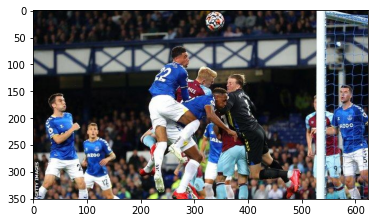

RESULT === This image looks like it was taken at a football stadium, with three people watching the game. One person looks like they're cheering, while the other two look neutrally observant. There might be an exciting moment happening in the game, based on the expressions on the people's faces.

VLM: This image is a:
0.1180 cartoon
0.1119 photo
0.1072 sketch
0.0752 painting

VLM: There:
0.1640 are three people
0.1594 are several people
0.1496 is one person
0.1459 are two people
0.1396 are many people

VLM: I think this photo was taken at a:
0.1462 football stadium
0.1459 iceberg
0.1360 cliff

VLM: I think there might be a:
0.2226 equalizer, equaliser
0.2174 goal
0.2172 handball
0.2093 brace
0.2000 big game
0.1945 pressing
0.1931 closer, finisher
0.1881 goalmouth
0.1865 net
0.1856 electrician, lineman, linesman

LM generated captions ranked by VLM scores:
0.2100 This image looks like it was taken at a football stadium, with three people watching the game. One person looks like they're 

In [ ]:
get_pic_caption('https://ichef.bbci.co.uk/onesport/cps/624/cpsprodpb/4AF4/production/_120588191_gettyimages-1340107690.jpg')

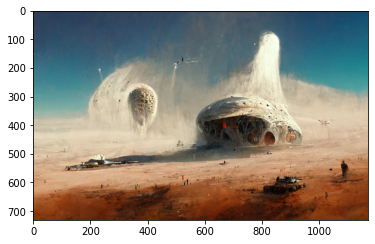

RESULT === This painting shows a junkyard or construction site. There are no people, but there is a pod or fuel tank in the foreground.

VLM: This image is a:
0.1642 painting
0.1627 sketch
0.1346 photo
0.1272 cartoon

VLM: There:
0.1428 no people
0.1423 people

VLM: I think this photo was taken at a:
0.1971 junkyard
0.1926 army base
0.1898 construction site

VLM: I think there might be a:
0.2077 pod, fuel pod
0.2013 structure, construction
0.2001 superstructure
0.1989 futurist
0.1984 fomite, vehicle
0.1980 junk
0.1976 environment, environs, surroundings, surround
0.1972 defensive structure, defense, defence
0.1964 rendezvous
0.1961 hoodoo

LM generated captions ranked by VLM scores:
0.2455 This painting shows a junkyard or construction site. There are no people, but there is a pod or fuel tank in the foreground.
0.2397 This painting shows a futurist junkyard full of abandoned pods and vehicles.
0.2369 A pod, fuel pod, structure, or construction site surrounded by a junkyard.
0.2272 Thi

In [ ]:
get_pic_caption('https://www.creativeshrimp.com/wp-content/uploads/2022/06/midjourney_aiart_gleb_alexandrov_22-1170x731.jpg')